# Trendanalyse en de BRO

_D.A. Brakenhoff, Artesia, 2025_

---

Dit notebook bevat een voorbeeld van de teopassing van de `krw_trendanalyse` op
een tijdreeks uit de BRO.

Voor het ophalen van de tijdreeks uit de BRO wordt de [`brodata` package](https://github.com/ArtesiaWater/brodata) gebruikt.

In [3]:
import brodata
import pastastore as pst
import krw_trendanalyse as krw
from pastastore.extensions import activate_hydropandas_extension
import hydropandas as hpd

activate_hydropandas_extension()
hpd.util.get_color_logger("ERROR", logger_name="hydropandas")

Registered HydroPandas extension in PastaStore class, e.g. `pstore.hpd.download_bro_gmw()`.


<Logger hydropandas (ERROR)>

Kies een GMW ID uit om het script mee te draaien.

In [4]:
bro_id = "GMW000000063133"

gmw = brodata.gmw.GroundwaterMonitoringWell.from_bro_id(bro_id)
gld = brodata.gmw.get_observations([bro_id])

We gebruiken PastaStore om de tijdreeksen in op te slaan, inclusief metadata. 

In [5]:
pstore = pst.PastaStore(name="temp")

oseries = gld["observation"].iloc[0].loc[:, "value"]
metadata = {
    "bro_id": bro_id,
    "well_code": gmw.wellCode,
    "nitg_code": gmw.nitgCode,
    "tube_nr": int(gmw.monitoringTube.index[0]),
    "screen_bottom": gmw.monitoringTube["screenBottomPosition"].item(),
    "screen_top": gmw.monitoringTube["screenTopPosition"].item(),
    "tube_top": gmw.monitoringTube["tubeTopPosition"].item(),
    "x": gmw.deliveredLocation.x,
    "y": gmw.deliveredLocation.y,
}
oname = f"{metadata["well_code"]}-{metadata["tube_nr"]:03g}"

pstore.add_oseries(oseries, oname, metadata=metadata)

De dichtstbijzijnde neerslag en verdamping kunnen automatisch worden opgehaald.

In [6]:
pstore.hpd.download_knmi_precipitation(tmin="1990-01-01")
pstore.hpd.download_knmi_evaporation(tmin="1990-01-01")

Maak een tijdreeksmodel.

In [7]:
ml = pstore.create_model(oname, add_recharge=True)
ml.solve()

Fit report GMW42D000543-001       Fit Statistics
nfev    20                     EVP         84.12
nobs    537                    R2           0.84
noise   False                  RMSE         0.11
tmin    1995-01-13 00:01:00    AICc     -2326.97
tmax    2022-06-28 10:44:06    BIC      -2309.90
freq    D                      Obj          3.47
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.       Yes

Parameters (4 optimized)
              optimal    initial  vary
recharge_A   0.139921   0.117885  True
recharge_a  60.222065  10.000000  True
recharge_f  -0.619707  -1.000000  True
constant_d   0.401294   0.759162  True


Kies de periodes waarover de trendanalyse moet worden toegepast.

In [8]:
periods = [
    ("2000", "2005"),
    ("2006", "2011"),
    ("2012", "2017"),
    ("2018", "2023"),
]
df_A = krw.mean_per_period(ml.oseries.series_original, periods)

Plotten van de gemiddeldes per periode van de oorspronkelijke tijdreeks.

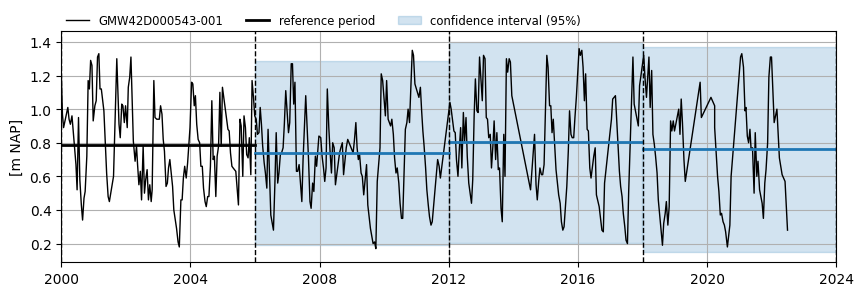

In [9]:
ax = krw.plots.plot_mean_per_period(ml.oseries.series_original, df_A)

Berekenen en plotten van de gemiddeldes per periode op basis van het tijdreeksmodel.

In [10]:
df_B = krw.model_residual_period_stats(ml=ml, periods=periods)
df_B

,reference,start,end,mean,var,Δmean,Δvar,ci
GMW42D000543-001,,,,,,,,
0,*,2000-01-01,2005-12-31,0.007077,0.000056,0.000000,0.000000,0.000000
1,,2006-01-01,2011-12-31,-0.002030,0.000042,-0.009107,0.000097,0.019314
2,,2012-01-01,2017-12-31,0.023003,0.000343,0.015926,0.000399,0.039148
3,,2018-01-01,2023-12-31,0.051022,0.001464,0.043944,0.001520,0.076404


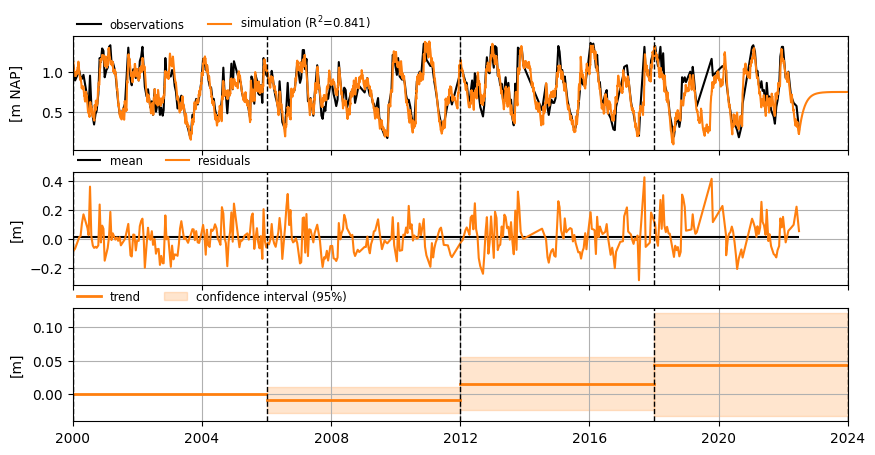

In [11]:
axes = krw.plots.plot_model_residuals_summary(ml, df_B, color="C1")

Vergelijking tussen de gemiddelde trends volgens de stijghoogtereeks zelf en
het tijdreeksmodel.

<Axes: ylabel='[m]'>

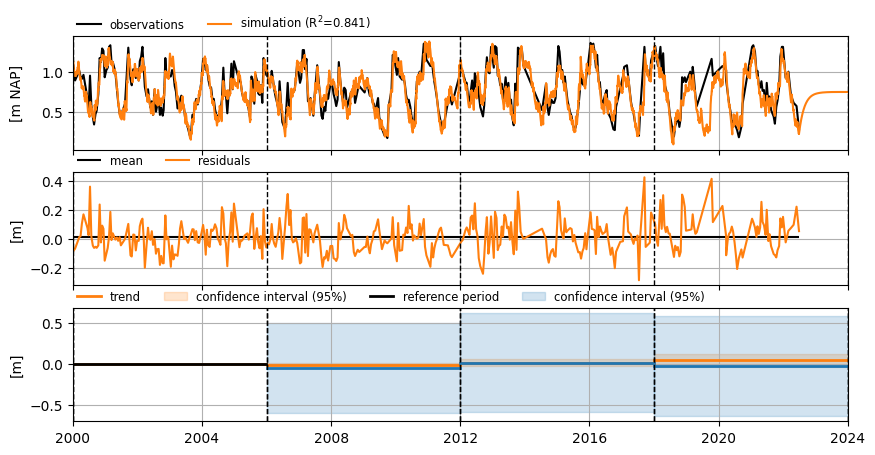

In [ ]:
axes = krw.plots.plot_model_residuals_summary(ml, df_B, color="C1")
krw.plots.plot_dmean_per_period(df_A, ax=axes[-1]);